<a href="https://colab.research.google.com/github/seisbench/seisbench/blob/additional_example_workflows/examples/03a_training_phasenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://raw.githubusercontent.com/seisbench/seisbench/main/docs/_static/seisbench_logo_subtitle_outlined.svg)

*This code is necessary on colab to install SeisBench. If SeisBench is already installed on your machine, you can skip this.*

In [ ]:
!pip install seisbench

*This cell is required to circumvent an issue with colab and obspy. For details, check this issue in the obspy documentation: https://github.com/obspy/obspy/issues/2547*

In [ ]:
try:
    import obspy
    obspy.read()
except TypeError:
    # Needs to restart the runtime once, because obspy only works properly after restart.
    print('Stopping RUNTIME. If you run this code for the first time, this is expected. Colaboratory will restart automatically. Please run again.')
    exit()

# Training PhaseNet

This tutorial shows how to train a model with SeisBench, using PhaseNet as an example. This brings together the three main components of SeisBench: data, models and generate.

The tutorial is intended to highlight the basic principles of training models in SeisBench. However, this will not necessarily be best practice for more elaborate experiments. As a reference how to set up larger studies and which augmentations can be used for which models, we refer to the implementation of our pick benchmark at [https://github.com/seisbench/pick-benchmark](https://github.com/seisbench/pick-benchmark).

*Note: As this tutorial brings together different parts of seisbench, it is recommended to go through the basic tutorials first before beginning this tutorial. In addition, this tutorial assumes some familiarity with pytorch*

In [1]:
import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
from seisbench.util import worker_seeding

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

## Model and data

We create a randomly initialized PhaseNet model using `seisbench.models`. If available, you can move your model onto GPU, running CUDA or MPS (on Apple silicon). In Google Colab, you can select a GPU under "Runtime > Change runtime type". 

In [2]:
model = sbm.PhaseNet(phases="PSN", norm="std", default_args={"blinding": (200, 200)})

if torch.cuda.is_available():
    model.cuda()
    print("Running on GPU")
elif torch.backends.mps.is_available():
    model.to("mps")
    print("Running on MPS")
else:
    print("Running on CPU")

Running on CPU


As training data we use the ETHZ dataset. Note that we set the sampling rate to 100 Hz to ensure that all examples are consistent in terms of sampling rate. We split the data into training, development and test sets according to the splits provided.

In [3]:
data = sbd.ETHZ(sampling_rate=100)
train, dev, test = data.train_dev_test()

2025-06-28 11:50:33,877 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb
2025-06-28 11:50:34,173 | seisbench | WARNING | Output component order not specified, defaulting to 'ZNE'.


## Generation pipeline

The ETHZ dataset contains detailed labels for the phases. However, for this example we only want to differentiate between P and S picks. Therefore, we define a dictionary mapping the detailed picks to their phases.

In [4]:
phase_dict = {
    "trace_p_arrival_sample": "P",
    "trace_pP_arrival_sample": "P",
    "trace_P_arrival_sample": "P",
    "trace_P1_arrival_sample": "P",
    "trace_Pg_arrival_sample": "P",
    "trace_Pn_arrival_sample": "P",
    "trace_PmP_arrival_sample": "P",
    "trace_pwP_arrival_sample": "P",
    "trace_pwPm_arrival_sample": "P",
    "trace_s_arrival_sample": "S",
    "trace_S_arrival_sample": "S",
    "trace_S1_arrival_sample": "S",
    "trace_Sg_arrival_sample": "S",
    "trace_SmS_arrival_sample": "S",
    "trace_Sn_arrival_sample": "S",
}

Now we define two generators with identical augmentations, one for training, one for validation. The augmentations are:
1. Selection of a (long) window around a pick. This way, we ensure that out data always contains a pick.
1. Selection of a random window with 3001 samples, the input length of PhaseNet.
1. A change of datatype to float32, as this is expected by the pytorch model.
1. A probabilistic label
   
Note that we do no normalization here. This will be done directly in the training lood with a builtin function of the model.

In [5]:
train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)

augmentations = [
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=3000, windowlen=6000, selection="random", strategy="variable"),
    sbg.RandomWindow(windowlen=3001, strategy="pad"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(label_columns=phase_dict, model_labels=model.labels, sigma=30, dim=0)
]

train_generator.add_augmentations(augmentations)
dev_generator.add_augmentations(augmentations)

Let's visualize a few training examples. Everytime you run the cell below, you'll see a different training example.

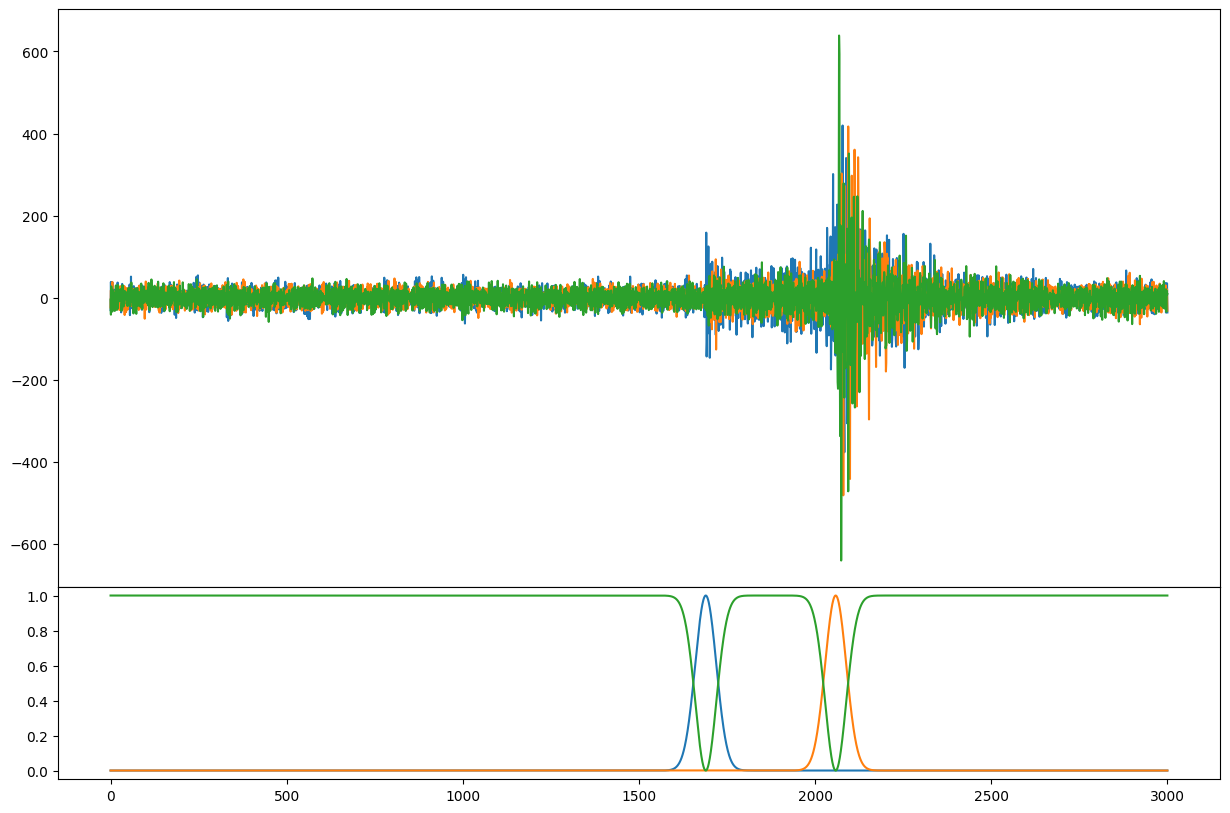

In [7]:
sample = train_generator[np.random.randint(len(train_generator))]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)

SeisBench generators are pytorch datasets. Therefore, we can pass them to pytorch data loaders. These will automatically take care of parallel loading and batching. Here we create one loader for training and one for validation. We choose a batch size of 256 samples. This batch size should fit on most hardware.

In [8]:
batch_size = 256
num_workers = 4  # The number of threads used for loading data

train_loader = DataLoader(train_generator, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_seeding)
dev_loader = DataLoader(dev_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding)

## Training a model

Now we got all components for training the model. What we still need to do is define the optimizer and the loss, and write the training and validation loops.

In [9]:
learning_rate = 1e-2
epochs = 5

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def loss_fn(y_pred, y_true, eps=1e-5):
    # vector cross entropy loss
    h = y_true * torch.log(y_pred + eps)
    h = h.mean(-1).sum(-1)  # Mean along sample dimension and sum along pick dimension
    h = h.mean()  # Mean over batch axis
    return -h

In [10]:
def train_loop(dataloader):
    size = len(dataloader.dataset)
    for batch_id, batch in enumerate(dataloader):
        # Compute prediction and loss
        x = batch["X"].to(model.device)
        x_preproc = model.annotate_batch_pre(x, {})  # Remove mean and normalize amplitude
        pred = model(x_preproc)
        loss = loss_fn(pred, batch["y"].to(model.device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_id % 5 == 0:
            loss, current = loss.item(), batch_id * batch["X"].shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader):
    num_batches = len(dataloader)
    test_loss = 0

    model.eval()  # close the model for evaluation

    with torch.no_grad():
        for batch in dataloader:
            x = batch["X"].to(model.device)
            x_preproc = model.annotate_batch_pre(x, {})  # Remove mean and normalize amplitude
            pred = model(x_preproc)
            test_loss += loss_fn(pred, batch["y"].to(model.device)).item()

    model.train()  # re-open model for training stage

    test_loss /= num_batches
    print(f"Test avg loss: {test_loss:>8f} \n")

*Note:* Depending on your hardware, this step might take a few minutes. We've set a low number of epochs to reduce runtime, but it might still take 5 to 20 minutes for your model to be trained (or even more on older hardware).

In [11]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader)
    test_loop(dev_loader)

Epoch 1
-------------------------------
loss: 1.127443  [    0/22626]
loss: 0.793141  [ 1280/22626]
loss: 0.564294  [ 2560/22626]
loss: 0.380694  [ 3840/22626]
loss: 0.267248  [ 5120/22626]
loss: 0.194675  [ 6400/22626]
loss: 0.160207  [ 7680/22626]
loss: 0.130984  [ 8960/22626]
loss: 0.120335  [10240/22626]
loss: 0.112375  [11520/22626]
loss: 0.103896  [12800/22626]
loss: 0.099277  [14080/22626]
loss: 0.093978  [15360/22626]
loss: 0.090473  [16640/22626]
loss: 0.090451  [17920/22626]
loss: 0.090317  [19200/22626]
loss: 0.087606  [20480/22626]
loss: 0.087328  [21760/22626]
Test avg loss: 0.089479 

Epoch 2
-------------------------------
loss: 0.090008  [    0/22626]
loss: 0.086942  [ 1280/22626]
loss: 0.090330  [ 2560/22626]
loss: 0.085048  [ 3840/22626]
loss: 0.086647  [ 5120/22626]
loss: 0.081969  [ 6400/22626]
loss: 0.082960  [ 7680/22626]
loss: 0.081288  [ 8960/22626]
loss: 0.083873  [10240/22626]
loss: 0.083529  [11520/22626]
loss: 0.080100  [12800/22626]
loss: 0.084411  [14080/2

## Evaluating the model

Not that we trained the model, we can evaluate it. First, we'll check how the model does on an example from the development set. Note that the model will most likely not be fully trained after only five epochs.

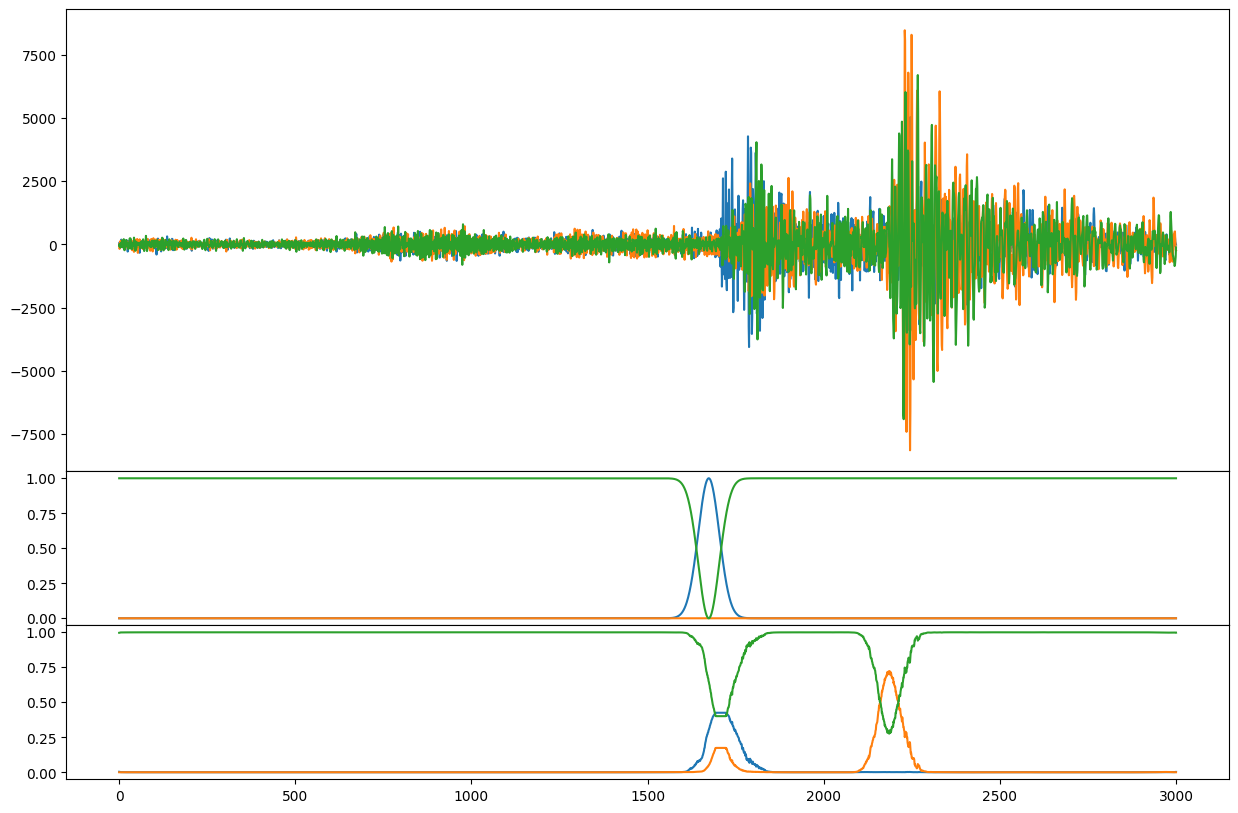

In [14]:
sample = dev_generator[np.random.randint(len(dev_generator))]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)

model.eval()  # close the model for evaluation

with torch.no_grad():
    x = torch.tensor(sample["X"]).to(model.device).unsqueeze(0)
    x_preproc = model.annotate_batch_pre(x, {})  # Remove mean and normalize amplitude
    pred = model(x_preproc)  # Add a fake batch dimension
    pred = pred[0].cpu().numpy()

axs[2].plot(pred.T)

As a second option, we'll directly apply our model to an obspy waveform stream using the `annotate` function. For this, we are downloading waveforms through FDSN and annotating them. Note that you could use the `classify` function in a similar fashion.

As we trained the model on Swiss data, we use an example event from Switzerland. Note that we deliberately chose a rather easy example, as the model is not fully trained after the low number of epochs. The exact performance of the model will vary depending, because the model training and initialization involves random aspects.

(0.0, 1.0)

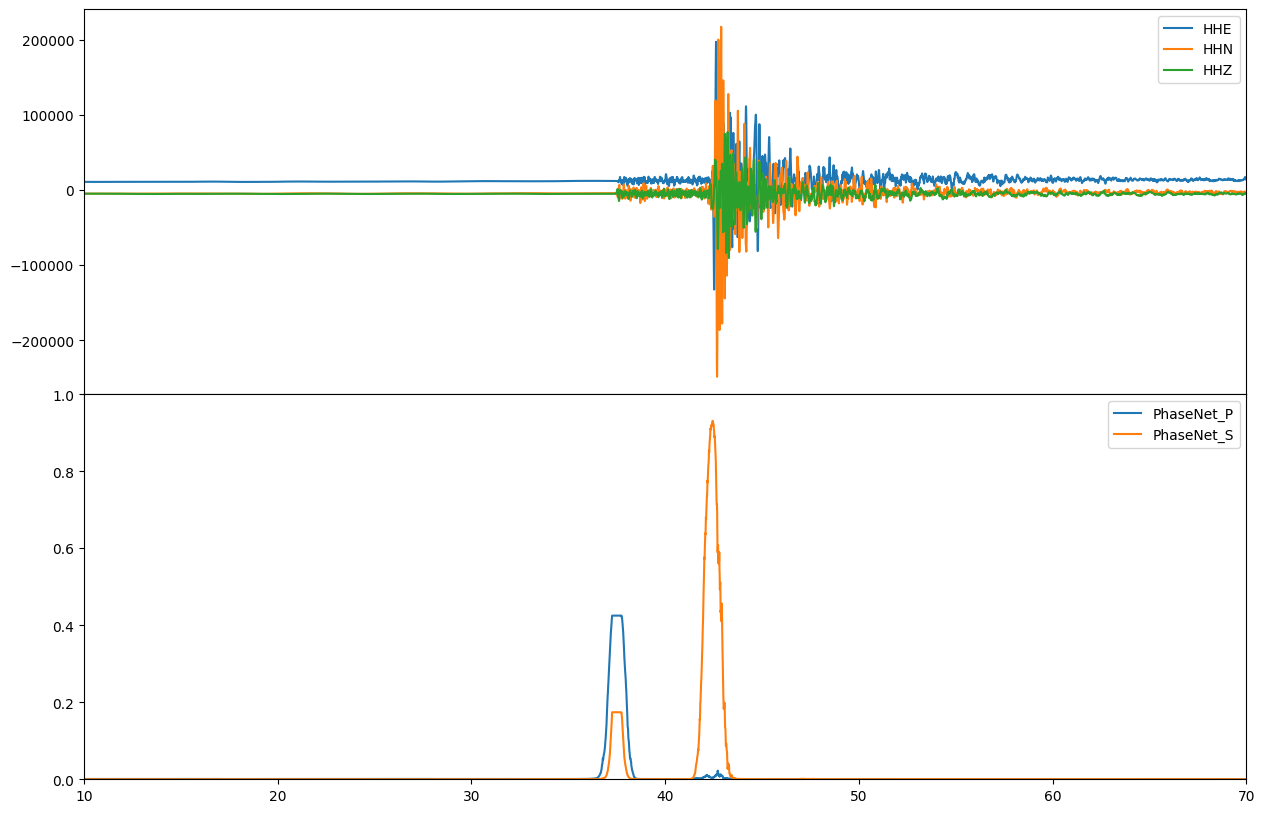

In [18]:
client = Client("ETH")

t = UTCDateTime("2019-11-04T00:59:46.419800Z")
stream = client.get_waveforms(network="CH", station="EMING", location="*", channel="HH?", starttime=t-30, endtime=t+50)

annotations = model.annotate(stream)

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0})

offset = annotations[0].stats.starttime - stream[0].stats.starttime
for i in range(3):
    axs[0].plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
    if annotations[i].stats.channel[-1] != "N":  # Do not plot noise curve
        axs[1].plot(annotations[i].times() + offset, annotations[i].data, label=annotations[i].stats.channel)

axs[0].legend()
axs[1].legend()
axs[0].set_xlim(10, 70)
axs[1].set_ylim(0, 1)

## Remarks

As discussed in the data basics tutorial, loading a SeisBench dataset only means loading the metadata into memory. The waveforms are only loaded once they are requested to save memory. By default, waveforms are **not** cached in memory. For training, this means that the data needs to be read from the file in every epoch again. Depending on your hardware, this will take a lot of time. To solve this issue, you can set the `cache` option, when creating the dataset. Then, all you have to do is call `preload_waveforms` and the data will be loaded into memory and automatically cached. For most practical applications, this option is recommended.

You might notice that for normalization we use the `annotate_batch_pre` function. This function implements all preprocessing on batch level, such as removing mean and normalizing the amplitude. The same function is used internally when calling `annotate` or `classify`. Using the same function in training ensures the consistent processing required for optimal performance.